In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import math

In [2]:
dataframe = pd.read_csv('preprocessedData.csv', index_col = 'ReadingDateTime', parse_dates = True)
dataframe

,BP,NO,NO2,NOX,SO2,SOLR,WDIR,WSPD
ReadingDateTime,,,,,,,,
2014-01-01 00:00:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:15:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:30:00,997.0,0.1,15.1,15.2,2.4,0.0,192.0,3.5
2014-01-01 00:45:00,997.0,0.1,15.1,15.2,2.4,0.0,209.0,3.5
2014-01-01 01:00:00,997.0,0.1,15.1,15.2,2.4,0.0,203.0,3.2
...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:00:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:15:00,1029.0,0.0,3.9,3.9,2.3,5.0,272.0,0.2


In [3]:
def shiftFiveReadings(dataframe, name):
    data = dataframe.copy()
    newColumn1 = name + "_Previous_1st_Reading"
    data[newColumn1] = dataframe[name].shift(+1)
      
    newColumn2 = name + "_Previous_2nd_Reading"
    data[newColumn2] = dataframe[name].shift(+2)
        
    newColumn3 = name + "_Previous_3rd_Reading"
    data[newColumn3] = dataframe[name].shift(+3)
        
    newColumn4 = name + "_Previous_4th_Reading"
    data[newColumn4] = dataframe[name].shift(+4)
       
    newColumn5 = name + "_Previous_5th_Reading"
    data[newColumn5] = dataframe[name].shift(+5)
    return data

In [4]:
dataframeA = shiftFiveReadings(dataframe, 'NO2')
dataframeA.interpolate(method = 'linear', axis = 0, limit_direction = 'both', inplace = True)
features = dataframeA[dataframeA.columns.difference(['NO2'])]
output = dataframeA['NO2']
training_features, testing_features, training_output, testing_output = train_test_split(features, output, test_size = 0.30)

In [5]:
NO_correlation_values = dataframeA.corr()['NO2'].drop('NO2')
weights = [NO_correlation_values['BP']]
weights.append(NO_correlation_values['NO'])
weights.append(NO_correlation_values['NO2_Previous_1st_Reading'])
weights.append(NO_correlation_values['NO2_Previous_2nd_Reading'])
weights.append(NO_correlation_values['NO2_Previous_3rd_Reading'])
weights.append(NO_correlation_values['NO2_Previous_4th_Reading'])
weights.append(NO_correlation_values['NO2_Previous_5th_Reading'])
weights.append(NO_correlation_values['NOX'])
weights.append(NO_correlation_values['SO2'])
weights.append(NO_correlation_values['SOLR'])
weights.append(NO_correlation_values['WDIR'])
weights.append(NO_correlation_values['WSPD'])

print(weights)

[0.0642443316239005, 0.5682523568692533, 0.9753659688299343, 0.9466185090107941, 0.917708373990282, 0.8882633138359132, 0.8583752508964937, 0.9296558955030992, 0.0744042639949021, -0.2415909438618176, -0.013307552569431547, -0.3655029292231375]


In [6]:
def pearsonWeightedDistance(vectorA, vectorB):
    return np.sqrt(np.sum(np.square(np.subtract(np.multiply(weights, vectorA), np.multiply(weights, vectorB)))))

In [7]:
knnRegressor = neighbors.KNeighborsRegressor(n_jobs = -1, n_neighbors = 11, metric = pearsonWeightedDistance)
knnRegressor.fit(training_features, training_output)

KNeighborsRegressor(metric=<function pearsonWeightedDistance at 0x0000019985567310>,
                    n_jobs=-1, n_neighbors=11)

In [8]:
start = time.time()

prediction = pd.Series(knnRegressor.predict(testing_features[0 : 500]), index = testing_features.index[0 : 500]).astype('float64')
print("1st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[500 : 1000]), index = testing_features.index[500 : 1000])])
print("2nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1000 : 1500]), index = testing_features.index[1000 : 1500])])
print("3rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1500 : 2000]), index = testing_features.index[1500 : 2000])])
print("4th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2000 : 2500]), index = testing_features.index[2000 : 2500])])
print("5th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2500 : 3000]), index = testing_features.index[2500 : 3000])])
print("6th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3000 : 3500]), index = testing_features.index[3000 : 3500])])
print("7th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3500 : 4000]), index = testing_features.index[3500 : 4000])])
print("8th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4000 : 4500]), index = testing_features.index[4000 : 4500])])
print("9th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4500 : 5000]), index = testing_features.index[4500 : 5000])])
print("10th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5000 : 5500]), index = testing_features.index[5000 : 5500])])
print("11th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5500 : 6000]), index = testing_features.index[5500 : 6000])])
print("12th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6000 : 6500]), index = testing_features.index[6000 : 6500])])
print("13th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6500 : 7000]), index = testing_features.index[6500 : 7000])])
print("14th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7000 : 7500]), index = testing_features.index[7000 : 7500])])
print("15th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7500 : 8000]), index = testing_features.index[7500 : 8000])])
print("16th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8000 : 8500]), index = testing_features.index[8000 : 8500])])
print("17th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8500 : 9000]), index = testing_features.index[8500 : 9000])])
print("18th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9000 : 9500]), index = testing_features.index[9000 : 9500])])
print("19th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9500 : 10000]), index = testing_features.index[9500 : 10000])])
print("20th iteration - ", time.time())

print(prediction)

1st iteration -  1651264814.051342
2nd iteration -  1651265310.172675
3rd iteration -  1651265890.035249
4th iteration -  1651266500.2994652
5th iteration -  1651267098.8825326
6th iteration -  1651267699.01429
7th iteration -  1651268316.4979124
8th iteration -  1651268924.145329
9th iteration -  1651269542.8107693
10th iteration -  1651270137.2490828
11th iteration -  1651270753.0052586
12th iteration -  1651271367.4644423
13th iteration -  1651271935.1432812
14th iteration -  1651272428.1680613
15th iteration -  1651272987.8065126
16th iteration -  1651273610.263338
17th iteration -  1651274224.4486463
18th iteration -  1651274836.659587
19th iteration -  1651275448.6890728
20th iteration -  1651276070.9333634
ReadingDateTime
2014-12-15 10:45:00    54.846212
2018-01-22 12:15:00    30.572727
2016-10-12 04:15:00    18.338483
2018-10-07 04:45:00     9.459924
2015-07-24 23:15:00     8.245455
                         ...    
2015-03-14 18:45:00    11.265269
2014-04-12 04:45:00     3.6636

In [9]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10000 : 10500]), index = testing_features.index[10000 : 10500])])
print("21st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10500 : 11000]), index = testing_features.index[10500 : 11000])])
print("22nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11000 : 11500]), index = testing_features.index[11000 : 11500])])
print("23rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11500 : 12000]), index = testing_features.index[11500 : 12000])])
print("24th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12000 : 12500]), index = testing_features.index[12000 : 12500])])
print("25th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12500 : 13000]), index = testing_features.index[12500 : 13000])])
print("26th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13000 : 13500]), index = testing_features.index[13000 : 13500])])
print("27th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13500 : 14000]), index = testing_features.index[13500 : 14000])])
print("28th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14000 : 14500]), index = testing_features.index[14000 : 14500])])
print("29th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14500 : 15000]), index = testing_features.index[14500 : 15000])])
print("30th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15000 : 15500]), index = testing_features.index[15000 : 15500])])
print("31st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15500 : 16000]), index = testing_features.index[15500 : 16000])])
print("32nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16000 : 16500]), index = testing_features.index[16000 : 16500])])
print("33rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16500 : 17000]), index = testing_features.index[16500 : 17000])])
print("34th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17000 : 17500]), index = testing_features.index[17000 : 17500])])
print("35th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17500 : 18000]), index = testing_features.index[17500 : 18000])])
print("36th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18000 : 18500]), index = testing_features.index[18000 : 18500])])
print("37th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18500 : 19000]), index = testing_features.index[18500 : 19000])])
print("38th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19000 : 19500]), index = testing_features.index[19000 : 19500])])
print("39th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19500 : 20000]), index = testing_features.index[19500 : 20000])])
print("40th iteration - ", time.time())

print(prediction)

21st iteration -  1651276690.0774572
22nd iteration -  1651277295.6381557
23rd iteration -  1651277921.672863
24th iteration -  1651278518.4542096
25th iteration -  1651279725.730853
26th iteration -  1651281184.989304
27th iteration -  1651282607.5209901
28th iteration -  1651284071.4420416
29th iteration -  1651285544.4513223
30th iteration -  1651287015.909065
31st iteration -  1651288473.2800753
32nd iteration -  1651289726.9103527
33rd iteration -  1651290747.3746524
34th iteration -  1651291875.6679833
35th iteration -  1651293017.8914223
36th iteration -  1651293744.6134808
37th iteration -  1651294485.288949
38th iteration -  1651295875.4347165
39th iteration -  1651296885.4807184
40th iteration -  1651297519.681936
ReadingDateTime
2014-12-15 10:45:00    54.846212
2018-01-22 12:15:00    30.572727
2016-10-12 04:15:00    18.338483
2018-10-07 04:45:00     9.459924
2015-07-24 23:15:00     8.245455
                         ...    
2014-10-05 14:00:00     4.090909
2016-02-23 16:45:00

In [10]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20000 : 20500]), index = testing_features.index[20000 : 20500])])
print("41st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20500 : 21000]), index = testing_features.index[20500 : 21000])])
print("42nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21000 : 21500]), index = testing_features.index[21000 : 21500])])
print("43rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21500 : 22000]), index = testing_features.index[21500 : 22000])])
print("44th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22000 : 22500]), index = testing_features.index[22000 : 22500])])
print("45th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22500 : 23000]), index = testing_features.index[22500 : 23000])])
print("46th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23000 : 23500]), index = testing_features.index[23000 : 23500])])
print("47th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23500 : 24000]), index = testing_features.index[23500 : 24000])])
print("48th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24000 : 24500]), index = testing_features.index[24000 : 24500])])
print("49th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24500 : 25000]), index = testing_features.index[24500 : 25000])])
print("50th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25000 : 25500]), index = testing_features.index[25000 : 25500])])
print("51st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25500 : 26000]), index = testing_features.index[25500 : 26000])])
print("52nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26000 : 26500]), index = testing_features.index[26000 : 26500])])
print("53rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26500 : 27000]), index = testing_features.index[26500 : 27000])])
print("54th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27000 : 27500]), index = testing_features.index[27000 : 27500])])
print("55th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27500 : 28000]), index = testing_features.index[27500 : 28000])])
print("56th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28000 : 28500]), index = testing_features.index[28000 : 28500])])
print("57th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28500 : 29000]), index = testing_features.index[28500 : 29000])])
print("58th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29000 : 29500]), index = testing_features.index[29000 : 29500])])
print("59th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29500 : 30000]), index = testing_features.index[29500 : 30000])])
print("60th iteration - ", time.time())

print(prediction)

41st iteration -  1651298931.5723891
42nd iteration -  1651300297.0258925
43rd iteration -  1651301628.6623266
44th iteration -  1651303040.0805252
45th iteration -  1651304413.819905
46th iteration -  1651305333.971765
47th iteration -  1651306063.4946766
48th iteration -  1651306817.7817888
49th iteration -  1651307639.519382
50th iteration -  1651308844.742944
51st iteration -  1651310287.2317424
52nd iteration -  1651311709.6162279
53rd iteration -  1651313165.9271815
54th iteration -  1651314392.9805224
55th iteration -  1651315313.313531
56th iteration -  1651316362.0738916
57th iteration -  1651317128.6372108
58th iteration -  1651317832.4756982
59th iteration -  1651318525.3654141
60th iteration -  1651319334.414955
ReadingDateTime
2014-12-15 10:45:00    54.846212
2018-01-22 12:15:00    30.572727
2016-10-12 04:15:00    18.338483
2018-10-07 04:45:00     9.459924
2015-07-24 23:15:00     8.245455
                         ...    
2018-04-16 05:00:00    30.863636
2018-12-09 13:45:00

In [11]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30000 : 30500]), index = testing_features.index[30000 : 30500])])
print("61st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30500 : 31000]), index = testing_features.index[30500 : 31000])])
print("62nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31000 : 31500]), index = testing_features.index[31000 : 31500])])
print("63rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31500 : 32000]), index = testing_features.index[31500 : 32000])])
print("64th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32000 : 32500]), index = testing_features.index[32000 : 32500])])
print("65th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32500 : 33000]), index = testing_features.index[32500 : 33000])])
print("66th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33000 : 33500]), index = testing_features.index[33000 : 33500])])
print("67th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33500 : 34000]), index = testing_features.index[33500 : 34000])])
print("68th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34000 : 34500]), index = testing_features.index[34000 : 34500])])
print("69th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34500 : 35000]), index = testing_features.index[34500 : 35000])])
print("70th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35000 : 35500]), index = testing_features.index[35000 : 35500])])
print("71st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35500 : 36000]), index = testing_features.index[35500 : 36000])])
print("72nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36000 : 36500]), index = testing_features.index[36000 : 36500])])
print("73rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36500 : 37000]), index = testing_features.index[36500 : 37000])])
print("74th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37000 : 37500]), index = testing_features.index[37000 : 37500])])
print("75th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37500 : 38000]), index = testing_features.index[37500 : 38000])])
print("76th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38000 : 38500]), index = testing_features.index[38000 : 38500])])
print("77th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38500 : 39000]), index = testing_features.index[38500 : 39000])])
print("78th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39000 : 39500]), index = testing_features.index[39000 : 39500])])
print("79th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39500 : 40000]), index = testing_features.index[39500 : 40000])])
print("80th iteration - ", time.time())

print(prediction)

61st iteration -  1651320103.366201
62nd iteration -  1651327358.710843
63rd iteration -  1651328748.6476083
64th iteration -  1651330161.227928
65th iteration -  1651331165.2692888
66th iteration -  1651332145.595446
67th iteration -  1651332766.192826
68th iteration -  1651333460.832295
69th iteration -  1651334244.7212732
70th iteration -  1651334956.1980164
71st iteration -  1651335596.0576205
72nd iteration -  1651336372.4478471
73rd iteration -  1651337161.4860997
74th iteration -  1651337941.3115678
75th iteration -  1651338565.814077
76th iteration -  1651339798.1399071
77th iteration -  1651341227.8270125
78th iteration -  1651342648.008234
79th iteration -  1651344030.9850466
80th iteration -  1651344989.1350763
ReadingDateTime
2014-12-15 10:45:00    54.846212
2018-01-22 12:15:00    30.572727
2016-10-12 04:15:00    18.338483
2018-10-07 04:45:00     9.459924
2015-07-24 23:15:00     8.245455
                         ...    
2016-10-03 17:45:00    51.652541
2014-02-13 01:45:00  

In [12]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40000 : 40500]), index = testing_features.index[40000 : 40500])])
print("81st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40500 : 41000]), index = testing_features.index[40500 : 41000])])
print("82nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41000 : 41500]), index = testing_features.index[41000 : 41500])])
print("83rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41500 : 42000]), index = testing_features.index[41500 : 42000])])
print("84th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42000 : 42500]), index = testing_features.index[42000 : 42500])])
print("85th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42500 : 43000]), index = testing_features.index[42500 : 43000])])
print("86th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43000 : 43500]), index = testing_features.index[43000 : 43500])])
print("87th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43500 : 44000]), index = testing_features.index[43500 : 44000])])
print("88th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44000 : 44500]), index = testing_features.index[44000 : 44500])])
print("89th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44500 : 45000]), index = testing_features.index[44500 : 45000])])
print("90th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45000 : 45500]), index = testing_features.index[45000 : 45500])])
print("91st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45500 : 46000]), index = testing_features.index[45500 : 46000])])
print("92nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46000 : 46500]), index = testing_features.index[46000 : 46500])])
print("93rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46500 : 47000]), index = testing_features.index[46500 : 47000])])
print("94th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47000 : 47500]), index = testing_features.index[47000 : 47500])])
print("95th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47500 : 48000]), index = testing_features.index[47500 : 48000])])
print("96th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48000 : 48500]), index = testing_features.index[48000 : 48500])])
print("97th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48500 : 49000]), index = testing_features.index[48500 : 49000])])
print("98th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49000 : 49500]), index = testing_features.index[49000 : 49500])])
print("99th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49500 : 50000]), index = testing_features.index[49500 : 50000])])
print("100th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50000 : 50500]), index = testing_features.index[50000 : 50500])])
print("101st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50500 : ]), index = testing_features.index[50500 : ])])
end = time.time()
print("102nd iteration - ", end)

print(prediction)

81st iteration -  1651346078.319367
82nd iteration -  1651347241.6884215
83rd iteration -  1651348653.091705
84th iteration -  1651350072.2846925
85th iteration -  1651351474.7600029
86th iteration -  1651352901.2072294
87th iteration -  1651354363.8113399
88th iteration -  1651355782.032803
89th iteration -  1651357177.9449792
90th iteration -  1651358587.7867336
91st iteration -  1651360020.4273098
92nd iteration -  1651361427.8361404
93rd iteration -  1651363104.209087
94th iteration -  1651364279.2455163
95th iteration -  1651365238.9024904
96th iteration -  1651366088.8864667
97th iteration -  1651366907.7350829
98th iteration -  1651367727.5397696
99th iteration -  1651368491.660965
100th iteration -  1651369171.1054115
101st iteration -  1651369707.8946419
102nd iteration -  1651370043.8101096
ReadingDateTime
2014-12-15 10:45:00    54.846212
2018-01-22 12:15:00    30.572727
2016-10-12 04:15:00    18.338483
2018-10-07 04:45:00     9.459924
2015-07-24 23:15:00     8.245455
       

In [13]:
mse = mean_squared_error(testing_output, prediction)
print("Mean Square Error = {}".format(mse))
  
r_square = r2_score(testing_output, prediction)
print("R-Square = {}".format(r_square))
    
mae = mean_absolute_error(testing_output, prediction)
print("Mean Absolute Error = {}".format(mae))
    
rmse = math.sqrt(mse)
print("Root Mean Square Error = {}".format(rmse))

Mean Square Error = 4.32036852712564
R-Square = 0.9778145656622411
Mean Absolute Error = 1.2930270992952175
Root Mean Square Error = 2.078549621040027


In [14]:
NO2 = pd.read_csv("NO2 Metrics.csv")
NO2.loc[len(NO2.index)] = [3.12, 'Attribute Weighted KNN Using Our Way (pearson)', 'sqrt(sum(sq(wu-wv)))', 'corr', 'no', start, end, rmse, mae, mse, r_square]
NO2.to_csv("NO2 Metrics.csv", index = False)

In [15]:
df = pd.concat({'Actual' : testing_output,
               'Predicted' : prediction}, 
              axis = 1)
df.to_csv("3.1.2(NO2).csv")

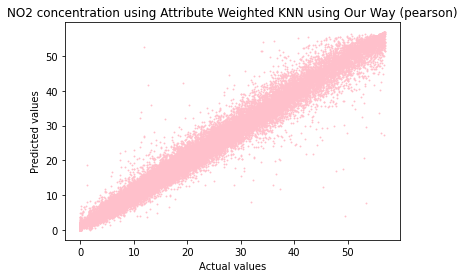

In [16]:
plt.scatter(testing_output, prediction, s = 0.75, c = 'pink')
plt.xlabel('Actual values')
plt.ylabel("Predicted values")
plt.title('NO2 concentration using Attribute Weighted KNN using Our Way (pearson)')
plt.show()